In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from sklearn.metrics import mean_squared_error as mse
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 15) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

In [3]:
def f_loss(x, axis, level, func):
    # Model.
    model = func(x.xs("FCG", axis = axis, level = level), x.xs("Forecast", axis = axis, level = level))
    # Naive.
    naive = func(x.xs("FCG", axis = axis, level = level), x.xs("Naive", axis = axis, level = level))  
    return pd.Series([model, naive], index = ["mse_model", "mse_naive"])

## Configuration

In [4]:
# Define the project analysis to visualize.
ANALYSIS_NAME = "Analysis 2022 Same Nb Provinces" 
PROJECT_ROOT = f"./RESULTS/{ANALYSIS_NAME}/"

In [5]:
COUNTRIES_ONLY_COLORS = ["Yemen", "Syria", "Burkina Faso", "Nigeria", "Mali", "Cameroon"] 
COLORS = {country: sns.color_palette("tab10")[i] for i, country in enumerate(COUNTRIES_ONLY_COLORS)}

## Yemen data managed in order to change n° provinces 

In [6]:
COUNTRIES = {"Yemen/7_provinces": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
             "Syria/7_provinces": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
             "Burkina Faso/7_provinces": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
             "Mali/7_provinces": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
             "Cameroon/7_provinces": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

In [7]:
NAMES = ["Yemen", "Syria", "Burkina Faso", "Mali", "Cameroon"]

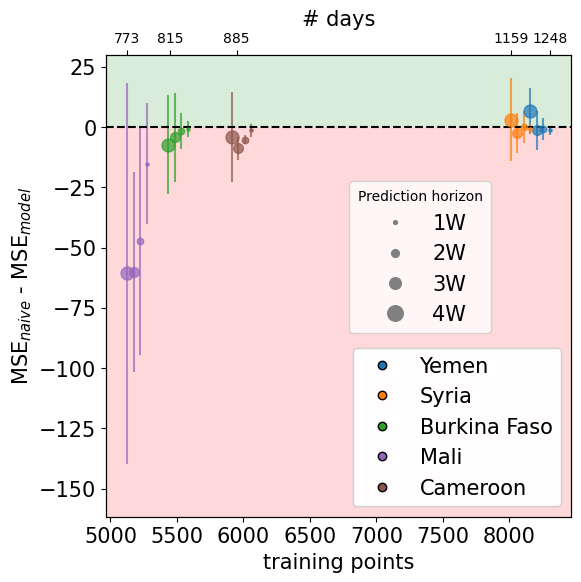

In [8]:
fig, axs = plt.subplots(figsize = (6, 6))

days_country = list()
for i, (COUNTRY, SEEDS) in enumerate(COUNTRIES.items()):
    forecast_all_seeds = {}
    # Forecasting results.
    for SEED in SEEDS:
        # Load forecasting results for each split.
        xls = pd.ExcelFile(PROJECT_ROOT + f"{COUNTRY}/{SEED}/out_test/forecast.xlsx")
        # FCG.
        fcg = pd.read_excel(xls, xls.sheet_names[0], index_col = 0, header = [0, 1, 2])
        forecast_all_splits = dict()
        days = list()
        for split in xls.sheet_names[1:]:
            forecast = pd.read_excel(xls, split, index_col = 0, header = [0, 1, 2])
            days.append(len(fcg.loc[:forecast.index[0]])-1)
            # Reset the index.
            forecast.index = np.arange(1, len(forecast) + 1)
            forecast.index.names = ["Prediction horizon"]
            # Save the predictions.
            forecast_all_splits[split] = forecast
        
        # We have the predictions for each split of the current seed.
        forecast_all_splits = pd.concat(forecast_all_splits, axis = 1)
        forecast_all_seeds[SEED] = forecast_all_splits

    # Concatenate all predictions over different seeds.
    forecast_all_seeds = pd.concat(forecast_all_seeds, axis = 1)
    forecast_all_seeds.columns.names = ["Seed", "Split", "Country", "AdminStrata", "Indicator"]
    
    # Load training shapes (indipendent by the seed).
    training_shape = pd.read_csv(PROJECT_ROOT + f"{COUNTRY}/{SEED}/out_test/training_shapes.csv", header = [0,1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)

    # Compute loss over prediction horizons (the seed are considered together during mse computation).
    loss_h = forecast_all_seeds.groupby(axis = 1, level = "Split").apply(lambda x: x.stack(["Country", "Indicator"]).groupby(axis = 0, level = ["Country", "Prediction horizon"]).apply(lambda x: f_loss(x, axis = 0, level = "Indicator", func = mse)))
    loss_h.columns.names = ["Split", "Type"]  
    
    results = loss_h.stack("Split")
    # For each split get difference between 'mse_naive' and 'mse_model'.
    results["diff"] =  results["mse_naive"] - results["mse_model"]
    results = results.unstack("Split").reorder_levels(["Split", "Type"], axis = 1).xs("diff", axis = 1, level = 1, drop_level = False)
    
    results = results.xs(NAMES[i], axis = 0)

    # Concatenate loss and training shape information.
    results = pd.concat([results, training_shape], axis = 1).sort_index(axis = 1)
    # Take the mean across all the splits.
    results_mean = results.groupby(axis = 1, level = 1).mean()
    results_std = results.groupby(axis = 1, level = 1).std()
    # Select some prediction horizon for visualiztion.
    results_mean = results_mean.loc[[7, 14, 21, 28]]
    results_std = results_std.loc[[7, 14, 21, 28]]
    
    if NAMES[i] == "Syria":
        days_country.append((int(np.mean(days)), training_shape.mean().mean()-130))
    else:
        days_country.append((int(np.mean(days)), training_shape.mean().mean()))

    for j in range(len(results_mean)):
        axs.errorbar(results_mean.iloc[j]["training points"], results_mean.iloc[j]["diff"],
                     yerr = results_std.iloc[j]["diff"], marker = "o", linestyle = "none", 
                     color = COLORS[NAMES[i]], markersize = results_mean.index[j]/3, 
                     alpha = 0.7)

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")

ax2 = axs.twiny()
ax2.plot([x[1] for x in days_country], np.ones(len(days_country)), alpha = 0) # Create a dummy plot
xticks = ax2.get_xticks()
ax2.set_xticks([x[1] for x in days_country])
ax2.set_xticklabels([str(x[0]) for x in days_country], fontdict = {'fontsize': 10})
ax2.set_xlabel("# days")

# Legend.
h = [plt.plot([],[], color = COLORS[NAMES[i]], marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i, sim in enumerate(NAMES)]
h = plt.legend(handles = h, labels = NAMES, loc = "lower right")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in results_mean.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"], loc = "upper right", bbox_to_anchor = (0.85,0.75), 
           title = "Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("MSE$_{naive}$ - MSE$_{model}$")

a = (axs.get_xlim()[0], axs.get_xlim()[1])
b = (axs.get_ylim()[0], 50)

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor = "green", alpha = 0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0]-30, facecolor = "red", alpha = 0.15)

axs.set_xlim(a)
axs.set_ylim((b[0]-14, 30))

fig.savefig("./IMAGES/Analysis 2022 Same Nb Provinces/Figure4a.png" , bbox_inches = "tight", dpi = 300)

## Time series visualization

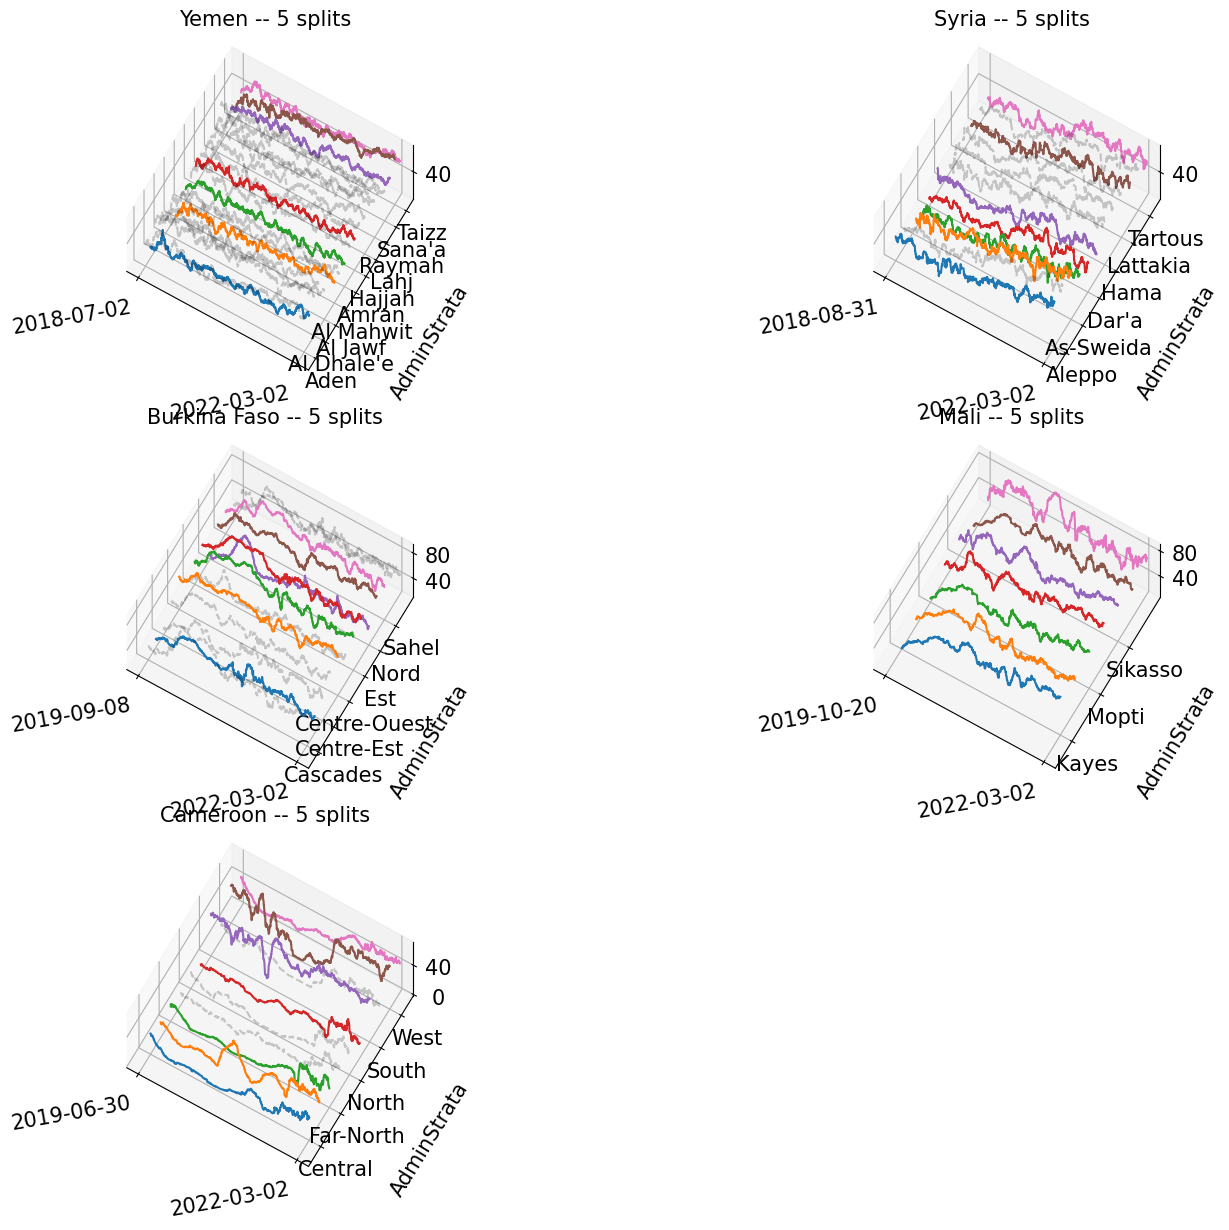

In [9]:
np.random.seed(0)

NAMES = ["Yemen", "Syria", "Burkina Faso", "Mali", "Cameroon"]
N_PROVINCES = [7, 7, 7, 7, 7]
SPLITS = [5, 5, 5, 5, 5]

fig, axs = plt.subplots(ncols = 2, nrows = 3, figsize = (20, 15), subplot_kw = dict(projection = "3d",  proj_type = "ortho"))
fig.subplots_adjust(hspace = .11, wspace = -.07)
axs = axs.ravel()

for ii, country in enumerate(NAMES):  
    # Load the data of the fcs indicator released by wfp.
    df = pd.read_csv(f"../../Dataset time-series/output_data/{country}/{country}.csv", header = [0, 1], index_col = 0)
    df = df.xs("FCG", axis = 1, level = 1, drop_level = False)
    df.index.name = "Datetime"
    df.index = pd.to_datetime(df.index)
    freq = "D"
    df.index.freq = freq
    
    # Select temporal range.
    START = df.first_valid_index()
    END = "2022-03-02"    
    df = df.loc[START:END]
    
    fcs = df.xs("FCG", axis = 1, level = 1)

    ax = axs[ii]
    # COLORED TIME-SERIES.    
    selected_provinces = np.random.choice(fcs.columns, N_PROVINCES[ii], replace = False)
    for i, column in enumerate(fcs.columns):
        if column in selected_provinces:
            ax.plot(np.arange(0, len(fcs)), fcs[column].values, zs = i+1, zdir = "y", 
                    zorder = (len(fcs) - i + 1), alpha = 1)
        else:
            ax.plot(np.arange(0, len(fcs)), fcs[column].values, zs = i+1, zdir = "y", 
                    zorder = (len(fcs) - i + 1), alpha = 0.2, color = "k", linestyle = "--")
            
    def mjrFormatter_date(x, pos):
        return fcs.index.strftime("%Y-%m-%d")[int(x)]
    
    def mjrFormatter_admin(x, pos):
        return fcs.columns.get_level_values("AdminStrata")[int(x)]

    ax.view_init(70, -60)
    #ax.set_xlabel("Datetime", rotation = 0, labelpad = 40)
    ax.set_ylabel("AdminStrata", rotation = 0, labelpad = 30)
    ax.set_ylim(0, len(fcs.columns))
    
    xs = set([int(fcs.index.get_loc(START)), int(fcs.index.get_loc(END))])
    ax.set_xticks(sorted(xs))
    ys = np.arange(1, len(fcs.columns), 2)
    ax.set_yticks(ys)
    ax.set_zticks([0, 40, 80])
    #ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter_date))
    ax.set_xticklabels([fcs.index.strftime("%Y-%m-%d")[0], fcs.index.strftime("%Y-%m-%d")[-1]], fontdict=None)
    #ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter_admin))
    ax.set_yticklabels([fcs.columns.get_level_values("AdminStrata")[y] for y in ys], fontdict=None)
    plt.setp(ax.get_xticklabels(), rotation = 10, ha = "right", rotation_mode = "anchor")
    plt.yticks(rotation = 0)
    ax.dist = 11
    
    ax.set_title(f"{NAMES[ii]} -- {SPLITS[ii]} splits", fontdict = dict(size = 15))
    
axs[-1].set_axis_off()    
# Save the figure.
fig.savefig(f"./IMAGES/Analysis 2022 Same Nb Provinces/Figure4b.png", dpi = 300, bbox_inches = "tight")

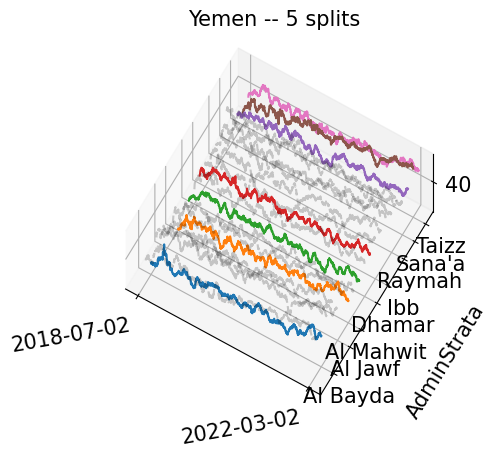

In [10]:
np.random.seed(0)

NAMES = ["Yemen"]#, "Syria", "Burkina Faso", "Mali", "Cameroon"]
N_PROVINCES = [7]#, 7, 7, 7, 7]
SPLITS = [5]#, 5, 5, 5, 5]

fig, ax = plt.subplots(figsize = (9, 5), subplot_kw = dict(projection = "3d",  proj_type = "ortho"))

for ii, country in enumerate(NAMES):  
    # Load the data of the fcs indicator released by wfp.
    df = pd.read_csv(f"../../Dataset time-series/output_data/{country}/{country}.csv", header = [0, 1], index_col = 0)
    df = df.xs("FCG", axis = 1, level = 1, drop_level = False)
    df.index.name = "Datetime"
    df.index = pd.to_datetime(df.index)
    freq = "D"
    df.index.freq = freq
    
    # Select temporal range.
    START = df.first_valid_index()
    END = "2022-03-02"    
    df = df.loc[START:END]

    # COLORED TIME-SERIES.
    fcs = df.xs("FCG", axis = 1, level = 1)
    selected_provinces = np.random.choice(fcs.columns, N_PROVINCES[ii], replace = False)
    for i, column in enumerate(fcs.columns):
        if column in selected_provinces:
            ax.plot(np.arange(0, len(fcs)), fcs[column].values, zs = i+1, zdir = "y", 
                    zorder = (len(fcs) - i + 1), alpha = 1)
        else:
            ax.plot(np.arange(0, len(fcs)), fcs[column].values, zs = i+1, zdir = "y", 
                    zorder = (len(fcs) - i + 1), alpha = 0.2, color = "k", linestyle = "--")
            
    def mjrFormatter_date(x, pos):
        return fcs.index.strftime("%Y-%m-%d")[int(x)]
    
    def mjrFormatter_admin(x, pos):
        return fcs.columns.get_level_values("AdminStrata")[int(x)]

    ax.view_init(70, -60)
    #ax.set_xlabel("Datetime", rotation = 0, labelpad = 40)
    ax.set_ylabel("AdminStrata", rotation = 0, labelpad = 30)
    ax.set_ylim(0, 20)
    
    xs = set([0, int(fcs.index.get_loc(START)), int(fcs.index.get_loc(END))])
    ax.set_xticks(sorted(xs))
    ax.set_yticks([2, 5, 7, 10, 12, 15, 17, 19])
    ax.set_zticks([0, 40, 80])
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter_date))
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter_admin))
    plt.setp(ax.get_xticklabels(), rotation = 10, ha = "right", rotation_mode = "anchor")
    plt.yticks(rotation = 0)
    ax.dist = 11
    
    ax.set_title(f"{NAMES[ii]} -- {SPLITS[ii]} splits", fontdict = dict(size = 15))

#axs[-1].set_axis_off()    
# Save the figure.
fig.savefig(f"./IMAGES/Analysis 2022 Same Nb Provinces/Figure4c.png", dpi = 300, bbox_inches = "tight")